<a href="https://colab.research.google.com/github/ELREVOstudio/ELREVOstudio/blob/main/Group_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

# Data Preparation and Preprocessing

In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn --quiet
# 2. Imports & Mounting Drive
# Import required libraries
import os
import numpy as np
import pandas as pd

# TensorFlow and Keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Define dataset path
image_dir = '/content/drive/MyDrive/UTKFace'

# Gather all image filenames from all subfolders
image_paths = []
for root, dirs, files in os.walk(image_dir):
    for fname in files:
        if fname.endswith('.jpg'):
            image_paths.append(os.path.join(root, fname))

print("Total images found:", len(image_paths))


Total images found: 24116


Preprocessing and Data Preparation

In [ ]:
import os
import pandas as pd

image_dir = '/content/drive/MyDrive/UTKFace'  # adjust path if needed

data = []
for root, dirs, files in os.walk(image_dir):
    for img in files:
        if img.endswith('.jpg'):
            try:
                age, gender, ethnicity, _ = img.split('_')
                full_path = os.path.join(root, img)
                data.append((full_path, img, int(age), int(gender), int(ethnicity)))
            except:
                continue

# Make sure to include 'full_path' as a column
df = pd.DataFrame(data, columns=['full_path', 'filename', 'age', 'gender', 'ethnicity'])

In [ ]:
# Create age_group and categorical age_class
def age_group(age):
    if age <= 12: return 'child'
    elif age <= 19: return 'teen'
    elif age <= 59: return 'adult'
    else: return 'senior'

df['age_group'] = df['age'].apply(age_group)
df['age_class'] = pd.Categorical(df['age_group'], categories=['child', 'teen', 'adult', 'senior']).codes


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['gender'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['gender'], random_state=42)

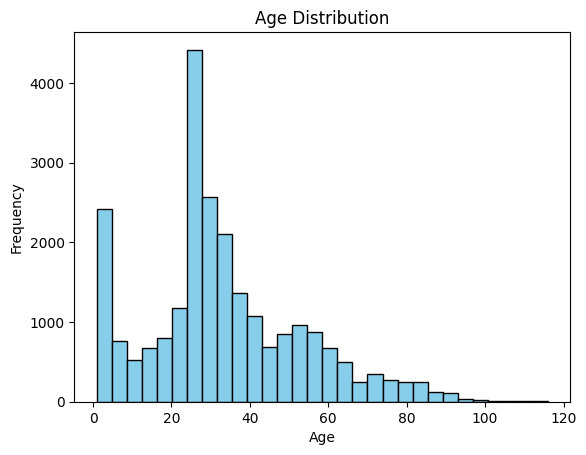

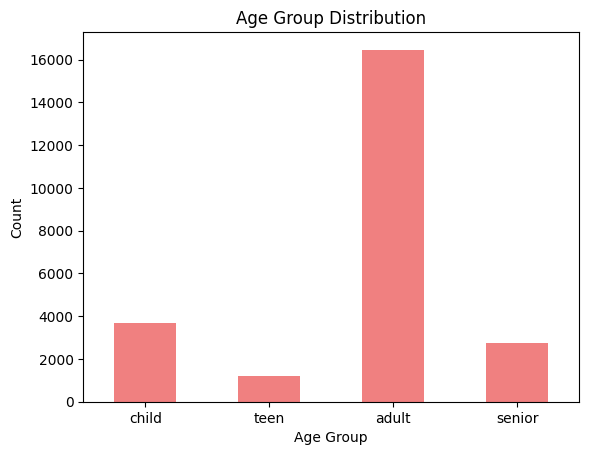

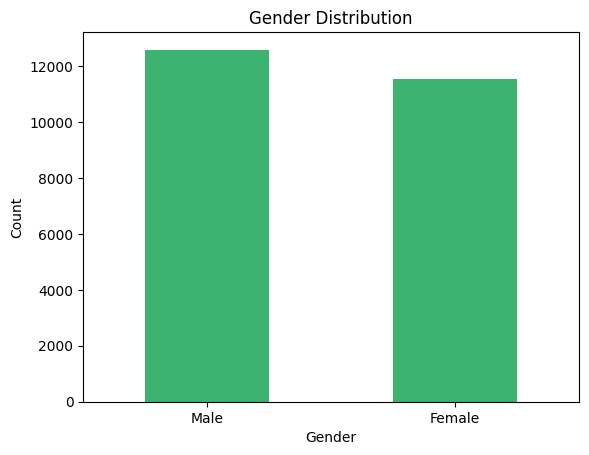

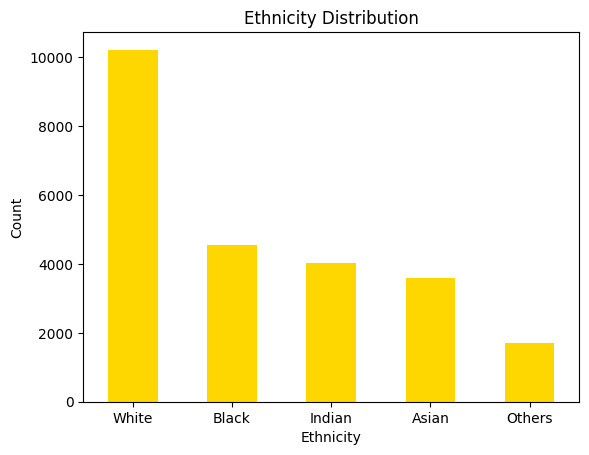

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- OPTIONAL: If not yet defined, create ethnicity label mapping
ethnicity_map = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}
df['ethnicity_label'] = df['ethnicity'].map(ethnicity_map)

# --- Create Age Group Labels
def age_group(age):
    if age <= 12:
        return 'child'
    elif age <= 19:
        return 'teen'
    elif age <= 59:
        return 'adult'
    else:
        return 'senior'

df['age_group'] = df['age'].apply(age_group)

# --- Plot 1: Age Distribution
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# --- Plot 2: Age Group Distribution
df['age_group'].value_counts().reindex(['child', 'teen', 'adult', 'senior']).plot(
    kind='bar',
    title='Age Group Distribution',
    color='lightcoral'
)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# --- Plot 3: Gender Distribution
df['gender'].value_counts().plot(
    kind='bar',
    title='Gender Distribution',
    color='mediumseagreen'
)
plt.xticks(ticks=[0, 1], labels=["Male", "Female"], rotation=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# --- Plot 4: Ethnicity Distribution
df['ethnicity_label'].value_counts().plot(
    kind='bar',
    title='Ethnicity Distribution',
    color='gold'
)
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


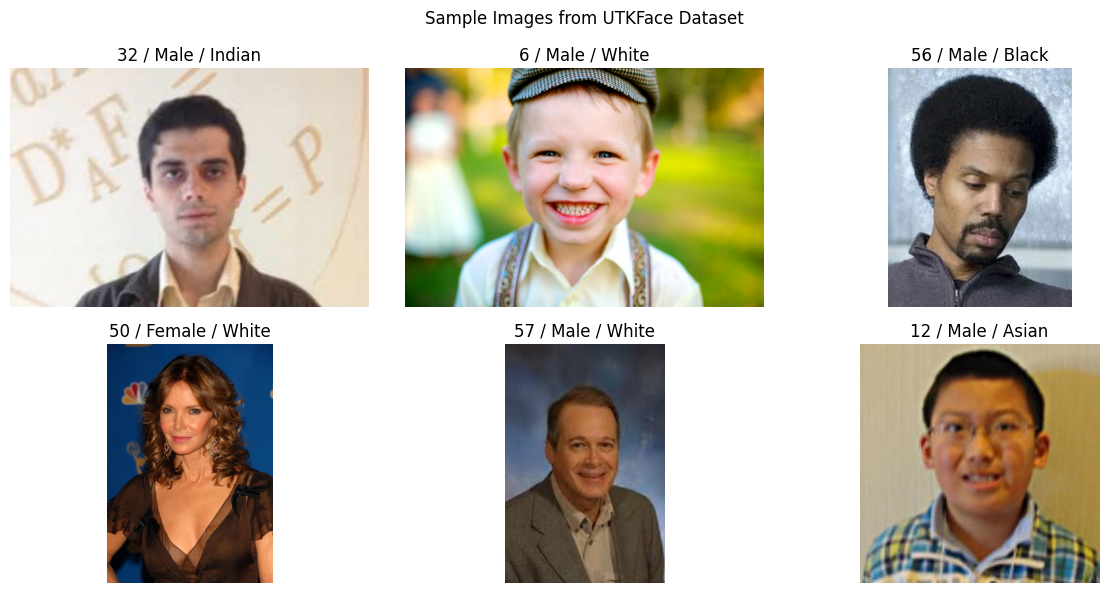

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Label mapping (if not already done)
df['gender_label'] = df['gender'].map({0: 'Male', 1: 'Female'})
df['ethnicity_label'] = df['ethnicity'].map({
    0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'
})

# Plot images
sample_imgs = df.sample(6)
plt.figure(figsize=(12, 6))
for i, (_, row) in enumerate(sample_imgs.iterrows()):
    img = mpimg.imread(row['full_path'])  # now this should exist
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{row['age']} / {row['gender_label']} / {row['ethnicity_label']}")
plt.suptitle("Sample Images from UTKFace Dataset")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class MultiOutputDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, img_size=(96, 96), shuffle=True, **kwargs):
        super().__init__(**kwargs)  # ✅ Required by Keras to support multiprocessing, etc.

        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size

        batch_df = self.df.iloc[start:end]

        X = np.array([
            preprocess_input(img_to_array(load_img(row['full_path'], target_size=self.img_size)))
            for _, row in batch_df.iterrows()
        ])


        y_gender = batch_df['gender'].values
        y_age = batch_df['age_class'].values
        y_ethnicity = batch_df['ethnicity'].values

        return X, {'gender': y_gender, 'age': y_age, 'ethnicity': y_ethnicity}

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [ ]:
#train_gen = MultiOutputDataGenerator(train_df, batch_size=32, img_size=(224, 224))
#val_gen = MultiOutputDataGenerator(val_df, batch_size=32, img_size=(224, 224), shuffle=False)

# Base MobileNetV2 Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))

# Freeze base layers (e.g., keep the first 100 layers frozen)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Unfreeze remaining layers for fine-tuning
for layer in base_model.layers[100:]:
    layer.trainable = True

# Add custom multi-output head
x = GlobalAveragePooling2D()(base_model.output)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)
age_output = Dense(4, activation='softmax', name='age')(x)
ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

model = Model(inputs=base_model.input, outputs=[gender_output, age_output, ethnicity_output])

# Compile with weighted losses to prioritize tasks (you can adjust weights later)
model.compile(
    optimizer=Adam(1e-4),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'gender': 1.0,
        'age': 1.5,
        'ethnicity': 1.5
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

<ipython-input-12-d44e7136d739>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=Adam(1e-3),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'gender': 1.0,
        'age': 1.5,
        'ethnicity': 1.2
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 398s 11s/step - age_accuracy: 0.6123 - age_loss: 1.1048 - ethnicity_accuracy: 0.3485 - ethnicity_loss: 1.7142 - gender_accuracy: 0.6783 - gender_loss: 0.6408 - loss: 4.4124 - val_age_accuracy: 0.7050 - val_age_loss: 2.9309 - val_ethnicity_accuracy: 0.3700 - val_ethnicity_loss: 2.5793 - val_gender_accuracy: 0.5400 - val_gender_loss: 1.1932 - val_loss: 8.8728
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - age_accuracy: 0.7997 - age_loss: 0.5612 - ethnicity_accuracy: 0.5469 - ethnicity_loss: 1.1748 - gender_accuracy: 0.7885 - gender_loss: 0.4502 - loss: 2.7023 - val_age_accuracy: 0.5750 - val_age_loss: 1.6388 - val_ethnicity_accuracy: 0.4200 - val_ethnicity_loss: 2.6521 - val_gender_accuracy: 0.5050 - val_gender_loss: 2.5587 - val_loss: 8.2992
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - age_accuracy: 0.8477 - age_loss: 0.3973 - ethnicity_accuracy: 0.6806 - ethnicity_loss: 0.8865 - gender_accuracy: 0.8786 - gender_loss: 0.3222 - loss: 1.9703 - val_ag

Classification Report:

GENDER Report:
              precision    recall  f1-score   support

        Male       0.54      0.97      0.69       101
      Female       0.82      0.14      0.24        99

    accuracy                           0.56       200
   macro avg       0.68      0.56      0.47       200
weighted avg       0.68      0.56      0.47       200



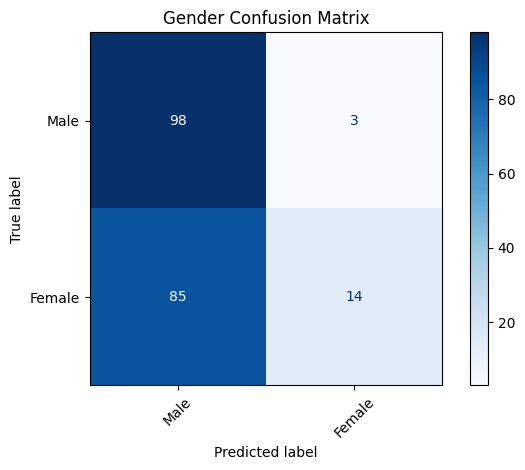


AGE Report:
              precision    recall  f1-score   support

        0–18       0.08      0.09      0.09        34
       19–30       0.00      0.00      0.00         9
       31–45       0.70      0.44      0.54       137
         46+       0.08      0.30      0.12        20

    accuracy                           0.34       200
   macro avg       0.21      0.21      0.19       200
weighted avg       0.50      0.34      0.40       200



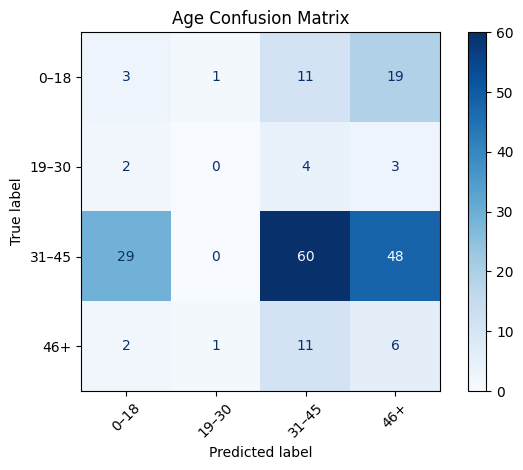


ETHNICITY Report:
              precision    recall  f1-score   support

       White       0.50      0.03      0.06        87
       Black       0.25      0.09      0.14        32
       Asian       0.38      0.15      0.21        34
      Indian       0.13      0.41      0.19        32
       Other       0.11      0.47      0.17        15

    accuracy                           0.15       200
   macro avg       0.27      0.23      0.16       200
weighted avg       0.35      0.15      0.13       200



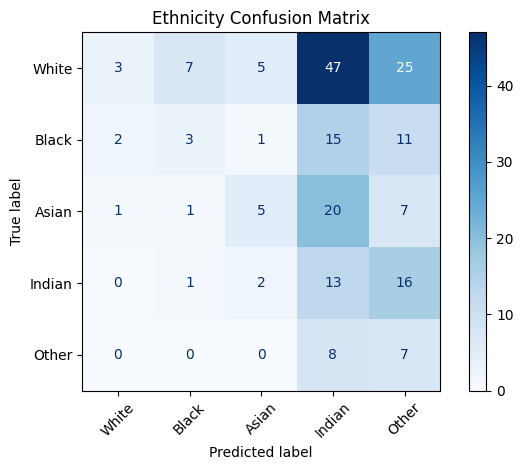


Gender Misclassifications: 88


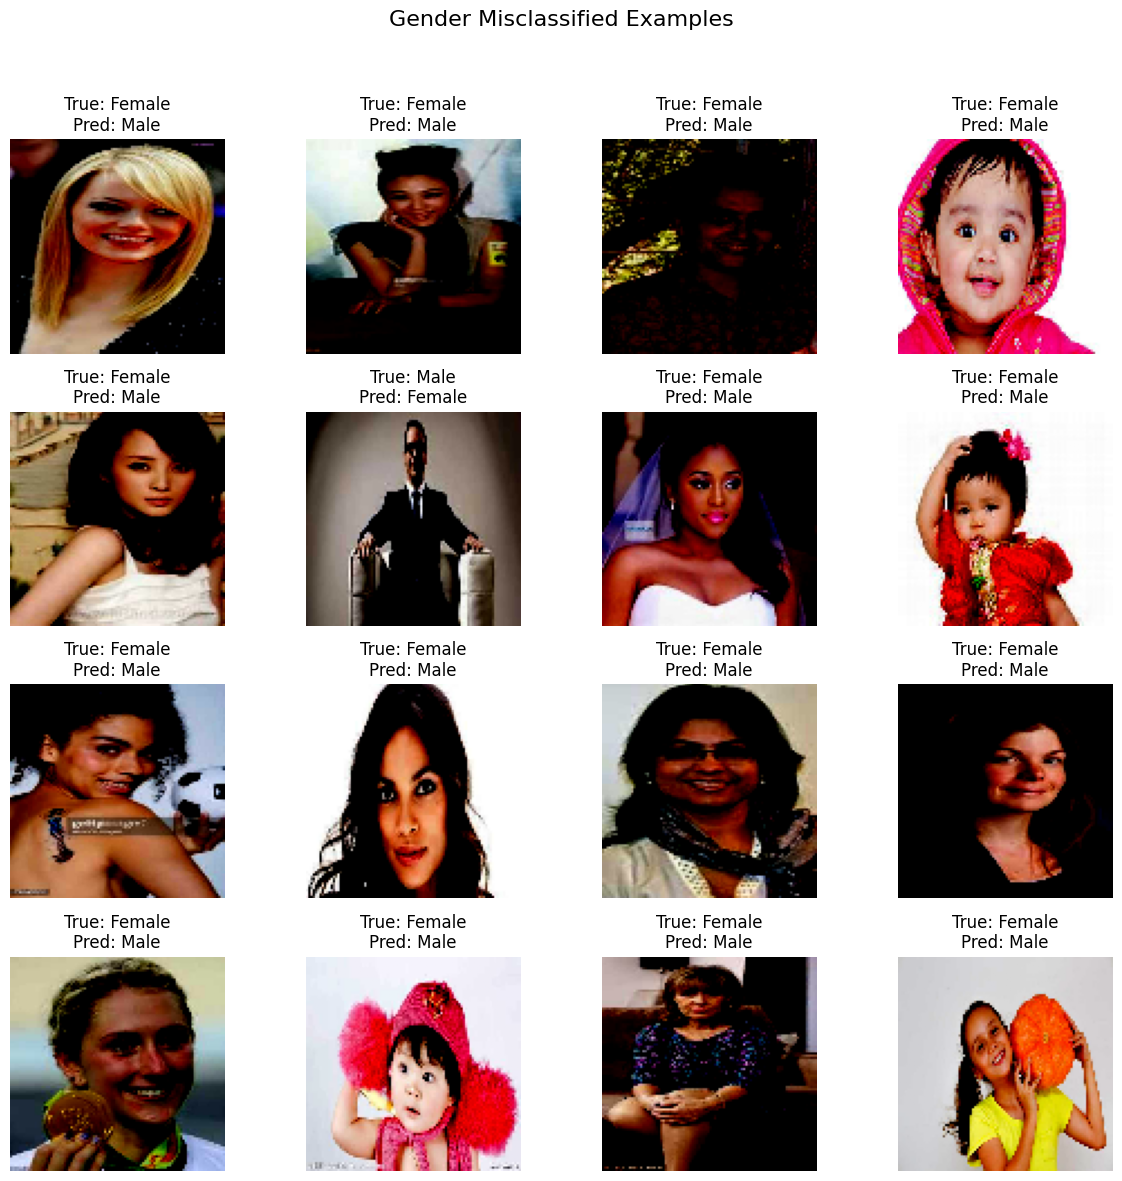


Age Misclassifications: 131


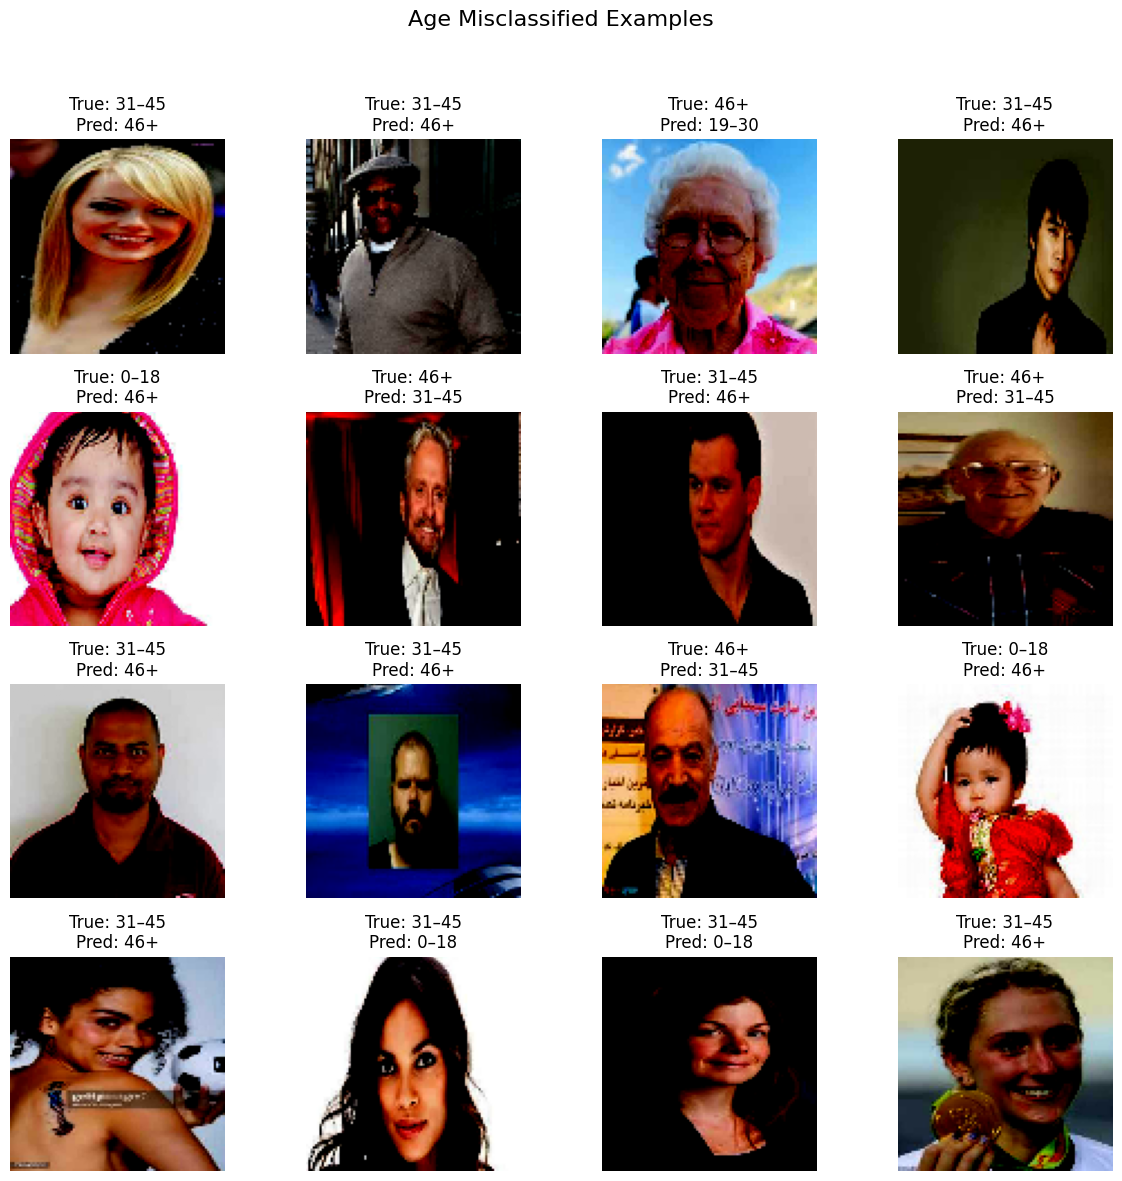


Ethnicity Misclassifications: 169


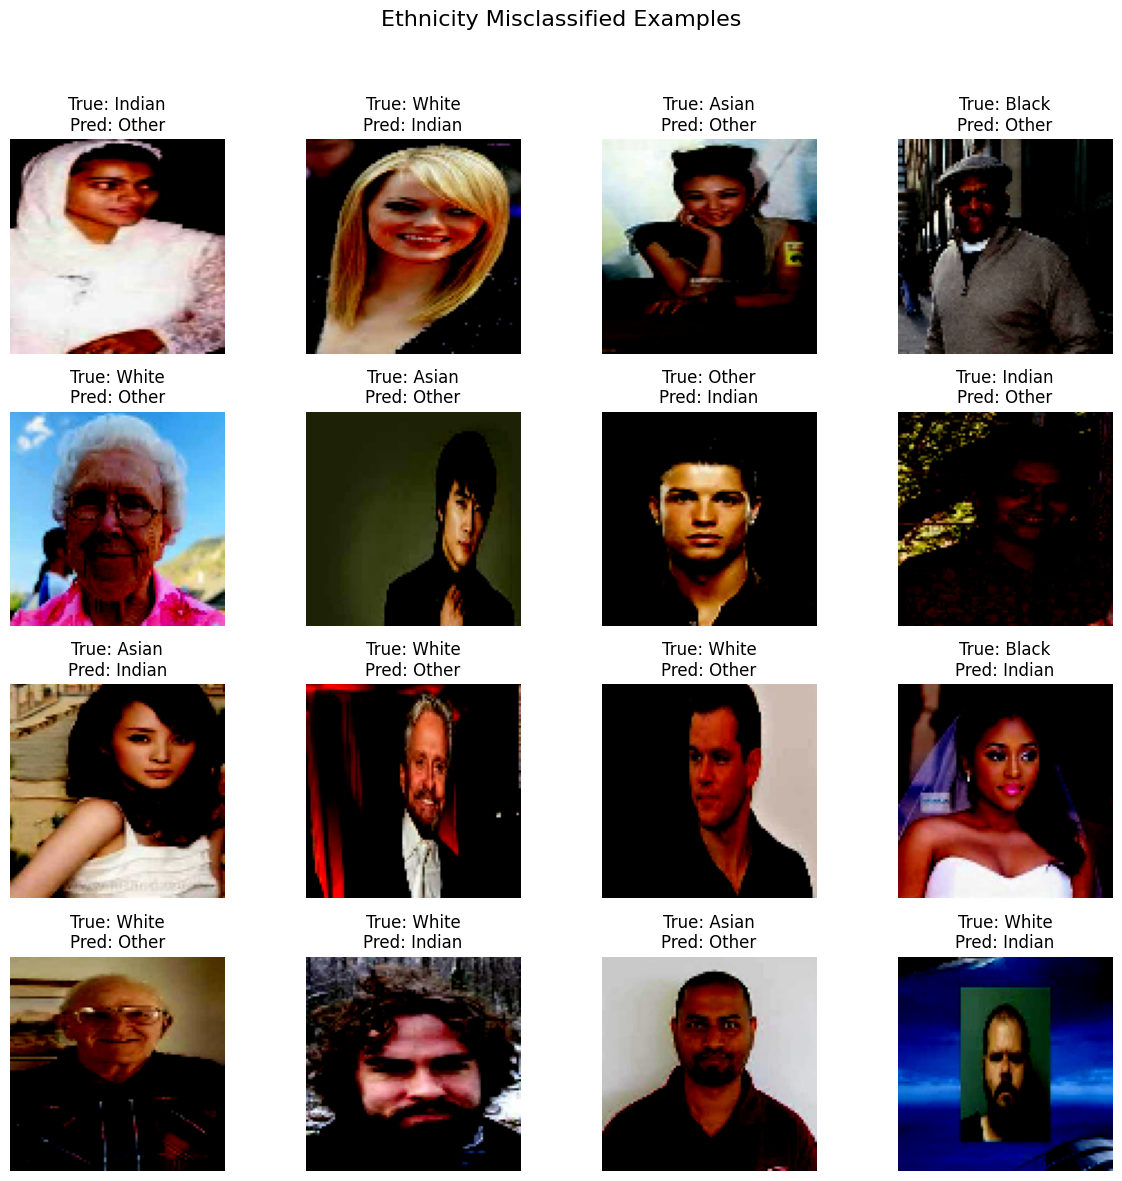

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Label mappings
gender_labels = {0: 'Male', 1: 'Female'}
age_labels = {0: '0–18', 1: '19–30', 2: '31–45', 3: '46+'}
ethnicity_labels = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'}

# Helper function to evaluate and visualize
def evaluate_model(model, val_gen):
    y_true = {'gender': [], 'age': [], 'ethnicity': []}
    y_pred = {'gender': [], 'age': [], 'ethnicity': []}
    all_images = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        preds = model.predict(batch_x, verbose=0)

        gender_pred = (preds[0] > 0.5).astype(int).flatten()
        age_pred = np.argmax(preds[1], axis=1)
        ethnicity_pred = np.argmax(preds[2], axis=1)

        y_true['gender'].extend(batch_y['gender'].flatten())
        y_true['age'].extend(batch_y['age'].flatten())
        y_true['ethnicity'].extend(batch_y['ethnicity'].flatten())

        y_pred['gender'].extend(gender_pred)
        y_pred['age'].extend(age_pred)
        y_pred['ethnicity'].extend(ethnicity_pred)

        all_images.extend(batch_x)

    # Classification Reports
    print("Classification Report:")
    for task, labels in zip(['gender', 'age', 'ethnicity'],
                            [gender_labels, age_labels, ethnicity_labels]):
        print(f"\n{task.upper()} Report:")
        print(classification_report(
            y_true[task], y_pred[task], target_names=list(labels.values())
        ))

        # Confusion Matrix
        cm = confusion_matrix(y_true[task], y_pred[task])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.values()))
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title(f"{task.capitalize()} Confusion Matrix")
        plt.tight_layout()
        plt.show()

    return y_true, y_pred, np.array(all_images)

# Error Visualizer
def plot_errors(X, y_true, y_pred, task_name, label_map, max_images=16):
    errors = np.where(np.array(y_true) != np.array(y_pred))[0]
    print(f"\n{task_name} Misclassifications: {len(errors)}")
    if len(errors) == 0:
        print("No misclassified examples found.")
        return

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(errors[:max_images]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[idx])
        plt.axis('off')
        true_label = label_map[y_true[idx]]
        pred_label = label_map[y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.suptitle(f"{task_name} Misclassified Examples", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run Evaluation + Error Analysis
y_true, y_pred, all_images = evaluate_model(model, val_gen)

# Misclassified Visuals for each task
plot_errors(all_images, y_true['gender'], y_pred['gender'], "Gender", gender_labels)
plot_errors(all_images, y_true['age'], y_pred['age'], "Age", age_labels)
plot_errors(all_images, y_true['ethnicity'], y_pred['ethnicity'], "Ethnicity", ethnicity_labels)


In [ ]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

# **Category 1 Change Dropout Rate**

#**0.2 DROPOUT RATE**

In [ ]:
# 1. Build Model with Dropout
from tensorflow.keras.layers import Dropout # Import the Dropout layer

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)  # Regularization

gender_output = Dense(1, activation='sigmoid', name='gender')(x)
age_output = Dense(4, activation='softmax', name='age')(x)
ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

model_exp1 = Model(inputs=base_model.input, outputs=[gender_output, age_output, ethnicity_output])

In [ ]:
# 2. Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# 3. Compile before initial training
model_exp1.compile(
    optimizer=Adam(1e-3),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [ ]:
# 4. Initial training
history_exp1 = model_exp1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 612ms/step - age_accuracy: 0.5560 - age_loss: 1.3856 - ethnicity_accuracy: 0.3633 - ethnicity_loss: 1.8676 - gender_accuracy: 0.5136 - gender_loss: 0.8409 - loss: 4.1003 - val_age_accuracy: 0.7800 - val_age_loss: 0.6411 - val_ethnicity_accuracy: 0.4200 - val_ethnicity_loss: 1.4956 - val_gender_accuracy: 0.8150 - val_gender_loss: 0.4648 - val_loss: 2.6175
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - age_accuracy: 0.7920 - age_loss: 0.6384 - ethnicity_accuracy: 0.4989 - ethnicity_loss: 1.3272 - gender_accuracy: 0.7701 - gender_loss: 0.4905 - loss: 2.4610 - val_age_accuracy: 0.8050 - val_age_loss: 0.5394 - val_ethnicity_accuracy: 0.4450 - val_ethnicity_loss: 1.3979 - val_gender_accuracy: 0.8200 - val_gender_loss: 0.3913 - val_loss: 2.3441
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 521ms/step - age_accuracy: 0.8204 - age_loss: 0.5738 - ethnicity_accuracy: 0.4925 - ethnicity_loss: 1.2627 - gender_accuracy: 0.8015 - gender_loss: 0.4080 - loss: 

In [ ]:
# 5. Unfreeze top 30 layers of base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 6. Re-compile with lower LR for fine-tuning
model_exp1.compile(
    optimizer=Adam(1e-5),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [ ]:
# 7. Fine-tuning
history_finetuned_exp1 = model_exp1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# 8. Evaluation
results = model_exp1.evaluate(val_gen, return_dict=True)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - age_accuracy: 0.5897 - age_loss: 0.9719 - ethnicity_accuracy: 0.5165 - ethnicity_loss: 1.2062 - gender_accuracy: 0.7633 - gender_loss: 0.4801 - loss: 2.6592 - val_age_accuracy: 0.8250 - val_age_loss: 0.5064 - val_ethnicity_accuracy: 0.5150 - val_ethnicity_loss: 1.2365 - val_gender_accuracy: 0.8300 - val_gender_loss: 0.3695 - val_loss: 2.1574
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 681ms/step - age_accuracy: 0.6765 - age_loss: 0.7962 - ethnicity_accuracy: 0.5650 - ethnicity_loss: 1.1070 - gender_accuracy: 0.7892 - gender_loss: 0.4379 - loss: 2.3552 - val_age_accuracy: 0.8250 - val_age_loss: 0.4860 - val_ethnicity_accuracy: 0.5300 - val_ethnicity_loss: 1.2940 - val_gender_accuracy: 0.8400 - val_gender_loss: 0.3748 - val_loss: 2.1523
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 809ms/step - age_accuracy: 0.6807 - age_loss: 0.7483 - ethnicity_accuracy: 0.5866 - ethnicity_loss: 1.0941 - gender_accuracy: 0.8202 - gender_loss: 0.4255 - loss: 2.2

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict
val_preds = model_exp1.predict(val_gen)

y_true_gender = val_df['gender'].values
# Use 'age_class' as this is what the generator outputs for age
y_true_age = val_df['age_class'].values
y_true_ethnicity = val_df['ethnicity'].values

# Get predicted classes
y_pred_gender = (val_preds[0] > 0.5).astype(int).flatten()
y_pred_age = np.argmax(val_preds[1], axis=1)
y_pred_ethnicity = np.argmax(val_preds[2], axis=1)

# Classification Reports
print("Classification Report - Gender:")
print(classification_report(y_true_gender, y_pred_gender, target_names=['Male', 'Female']))

print("Classification Report - Age:")
# You might want to add target_names for age and ethnicity for clarity
print(classification_report(y_true_age, y_pred_age, target_names=['Child', 'Teen', 'Adult', 'Senior'])) # Added age labels
print("\nClassification Report - Ethnicity:") # Added newline for readability
print(classification_report(y_true_ethnicity, y_pred_ethnicity, target_names=['White', 'Black', 'Asian', 'Indian', 'Others'])) # Added ethnicity labels

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step
Classification Report - Gender:
              precision    recall  f1-score   support

        Male       0.47      0.52      0.49       102
      Female       0.44      0.39      0.41        98

    accuracy                           0.46       200
   macro avg       0.45      0.45      0.45       200
weighted avg       0.45      0.46      0.45       200

Classification Report - Age:
              precision    recall  f1-score   support

       Child       0.23      0.20      0.21        30
        Teen       0.00      0.00      0.00         7
       Adult       0.71      0.84      0.77       137
      Senior       0.10      0.04      0.06        26

    accuracy                           0.61       200
   macro avg       0.26      0.27      0.26       200
weighted avg       0.53      0.61      0.57       200


Classification Report - Ethnicity:
              precision    recall  f1-score   support

       White       0.42      0.54      0.47    

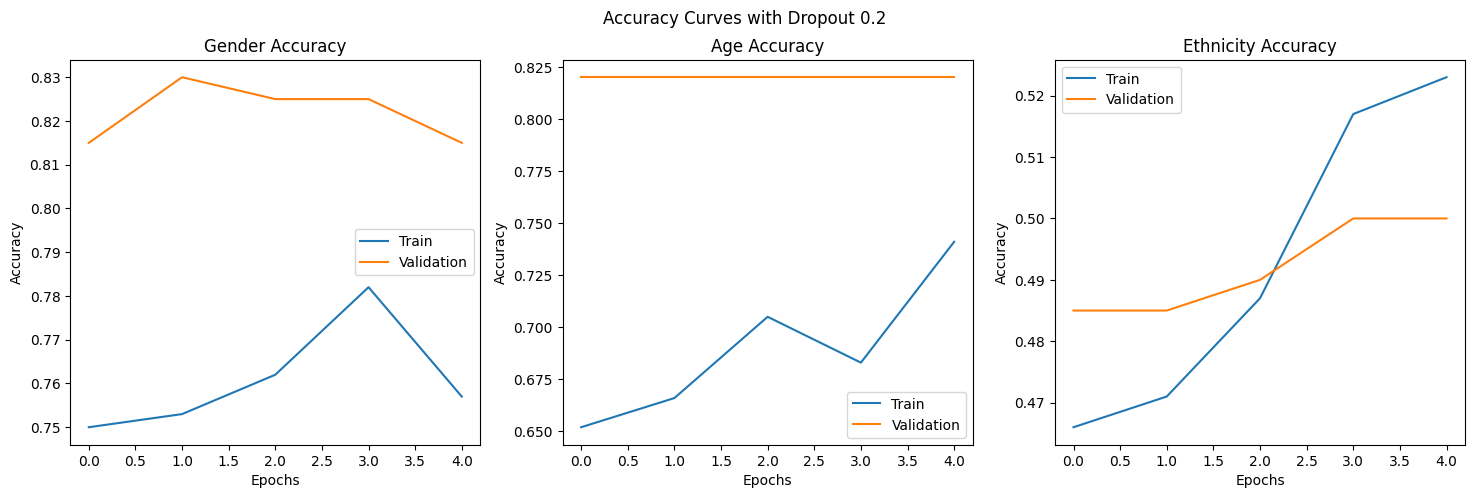

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import pandas as pd

# Plot Accuracy Curves
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(18, 5))

    for i, metric in enumerate([('gender', 'Gender Accuracy'),
                                ('age', 'Age Accuracy'),
                                ('ethnicity', 'Ethnicity Accuracy')]):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[f'{metric[0]}_accuracy'], label='Train')
        plt.plot(history.history[f'val_{metric[0]}_accuracy'], label='Validation')
        plt.title(metric[1])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.suptitle(title)
    plt.show()

plot_training_history(history_finetuned_exp1, "Accuracy Curves with Dropout 0.2")



7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step


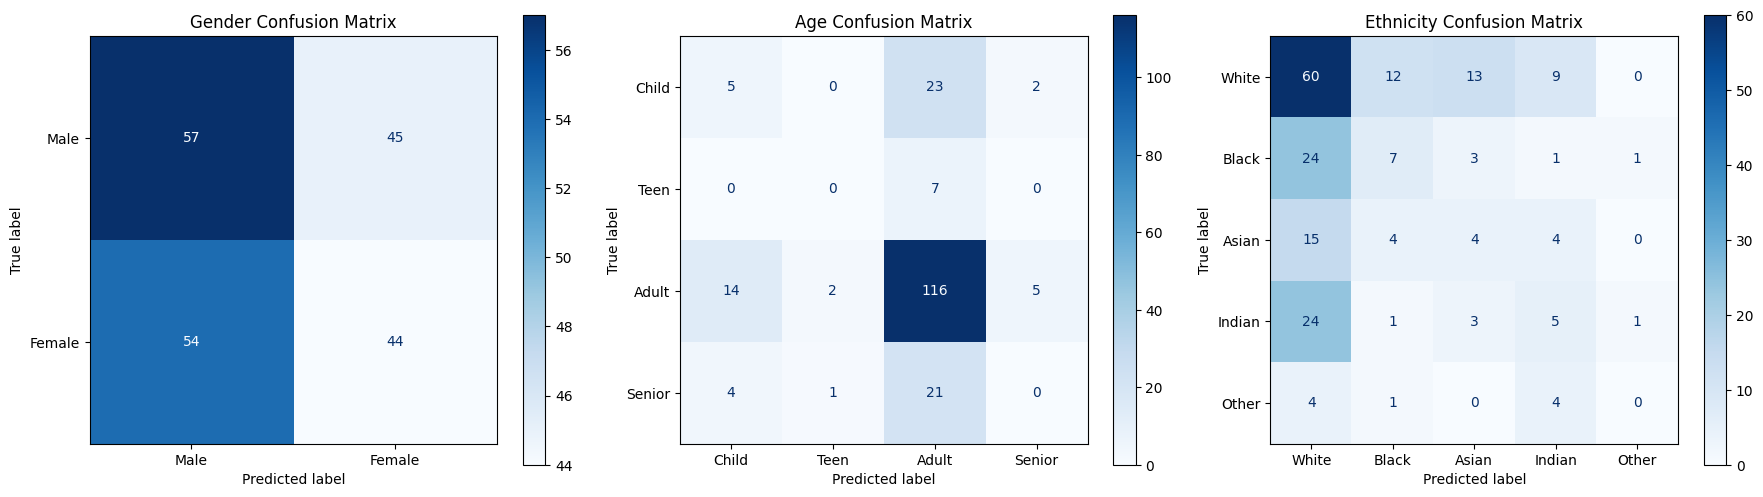

In [ ]:
# Predict on validation data
val_preds = model_exp1.predict(val_gen)
pred_gender = (val_preds[0] > 0.5).astype(int).flatten()
pred_age = np.argmax(val_preds[1], axis=1)
pred_ethnicity = np.argmax(val_preds[2], axis=1)

true_gender = val_df['gender'].values
true_age = val_df['age_class'].values # Use 'age_class' as this is what the generator outputs for age
true_ethnicity = val_df['ethnicity'].values

# Confusion matrices
plt.figure(figsize=(18, 5))
for i, (true, pred, title, labels) in enumerate([
    (true_gender, pred_gender, "Gender", ["Male", "Female"]),
    (true_age, pred_age, "Age", ["Child", "Teen", "Adult", "Senior"]), # Updated age labels to match age_class
    (true_ethnicity, pred_ethnicity, "Ethnicity", ["White", "Black", "Asian", "Indian", "Other"]),
]):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=plt.gca(), values_format='d')
    plt.title(f"{title} Confusion Matrix")

plt.tight_layout()
plt.show()


#**0.4 Dropout Rate**

In [ ]:
# 1. Build Model with Dropout
from tensorflow.keras.layers import Dropout # Import the Dropout layer

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)  # Regularization

gender_output = Dense(1, activation='sigmoid', name='gender')(x)
age_output = Dense(4, activation='softmax', name='age')(x)
ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

model_exp2 = Model(inputs=base_model.input, outputs=[gender_output, age_output, ethnicity_output])


In [ ]:
# 2. Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# 3. Compile before initial training
model_exp2.compile(
    optimizer=Adam(1e-3),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [ ]:
# 4. Initial training
history_exp2 = model_exp2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 595ms/step - age_accuracy: 0.5544 - age_loss: 1.3970 - ethnicity_accuracy: 0.3588 - ethnicity_loss: 1.7743 - gender_accuracy: 0.6096 - gender_loss: 0.7681 - loss: 3.9407 - val_age_accuracy: 0.7550 - val_age_loss: 0.7570 - val_ethnicity_accuracy: 0.4650 - val_ethnicity_loss: 1.4307 - val_gender_accuracy: 0.7950 - val_gender_loss: 0.4915 - val_loss: 2.7182
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 524ms/step - age_accuracy: 0.7366 - age_loss: 0.7814 - ethnicity_accuracy: 0.4479 - ethnicity_loss: 1.3909 - gender_accuracy: 0.7627 - gender_loss: 0.4884 - loss: 2.6693 - val_age_accuracy: 0.8000 - val_age_loss: 0.6796 - val_ethnicity_accuracy: 0.4950 - val_ethnicity_loss: 1.3572 - val_gender_accuracy: 0.8250 - val_gender_loss: 0.4435 - val_loss: 2.4388
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 527ms/step - age_accuracy: 0.8035 - age_loss: 0.5866 - ethnicity_accuracy: 0.5392 - ethnicity_loss: 1.2123 - gender_accuracy: 0.8114 - gender_loss: 0.3986 - loss: 

In [ ]:
# 5. Unfreeze top 30 layers of base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 6. Re-compile with lower LR for fine-tuning
model_exp2.compile(
    optimizer=Adam(1e-5),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [ ]:
# 7. Fine-tuning
history_finetuned_exp2 = model_exp2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# 8. Evaluation
results = model_exp2.evaluate(val_gen, return_dict=True)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 849ms/step - age_accuracy: 0.8277 - age_loss: 0.4673 - ethnicity_accuracy: 0.6616 - ethnicity_loss: 0.8727 - gender_accuracy: 0.8598 - gender_loss: 0.3389 - loss: 1.6840 - val_age_accuracy: 0.7950 - val_age_loss: 0.6168 - val_ethnicity_accuracy: 0.5450 - val_ethnicity_loss: 1.2219 - val_gender_accuracy: 0.8450 - val_gender_loss: 0.4304 - val_loss: 2.2676
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 655ms/step - age_accuracy: 0.8587 - age_loss: 0.4173 - ethnicity_accuracy: 0.6867 - ethnicity_loss: 0.7989 - gender_accuracy: 0.8560 - gender_loss: 0.3293 - loss: 1.5450 - val_age_accuracy: 0.7950 - val_age_loss: 0.6367 - val_ethnicity_accuracy: 0.5400 - val_ethnicity_loss: 1.1195 - val_gender_accuracy: 0.8450 - val_gender_loss: 0.4014 - val_loss: 2.2796
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 689ms/step - age_accuracy: 0.8342 - age_loss: 0.4274 - ethnicity_accuracy: 0.7262 - ethnicity_loss: 0.7926 - gender_accuracy: 0.8819 - gender_loss: 0.2846 - loss: 

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict
val_preds = model_exp2.predict(val_gen)

y_true_gender = val_df['gender'].values
# Use 'age_class' as this is what the generator outputs for age
y_true_age = val_df['age_class'].values
y_true_ethnicity = val_df['ethnicity'].values

# Get predicted classes
y_pred_gender = (val_preds[0] > 0.5).astype(int).flatten()
y_pred_age = np.argmax(val_preds[1], axis=1)
y_pred_ethnicity = np.argmax(val_preds[2], axis=1)

# Classification Reports
print("Classification Report - Gender:")
print(classification_report(y_true_gender, y_pred_gender, target_names=['Male', 'Female']))

print("Classification Report - Age:")
# You might want to add target_names for age and ethnicity for clarity
print(classification_report(y_true_age, y_pred_age, target_names=['Child', 'Teen', 'Adult', 'Senior'])) # Added age labels
print("\nClassification Report - Ethnicity:") # Added newline for readability
print(classification_report(y_true_ethnicity, y_pred_ethnicity, target_names=['White', 'Black', 'Asian', 'Indian', 'Others'])) # Added ethnicity labels

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step
Classification Report - Gender:
              precision    recall  f1-score   support

        Male       0.53      0.57      0.55       102
      Female       0.51      0.47      0.49        98

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.52      0.52      0.52       200

Classification Report - Age:
              precision    recall  f1-score   support

       Child       0.13      0.10      0.11        30
        Teen       0.00      0.00      0.00         7
       Adult       0.68      0.80      0.73       137
      Senior       0.25      0.15      0.19        26

    accuracy                           0.58       200
   macro avg       0.26      0.26      0.26       200
weighted avg       0.52      0.58      0.54       200


Classification Report - Ethnicity:
              precision    recall  f1-score   support

       White       0.53      0.56      0.55    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


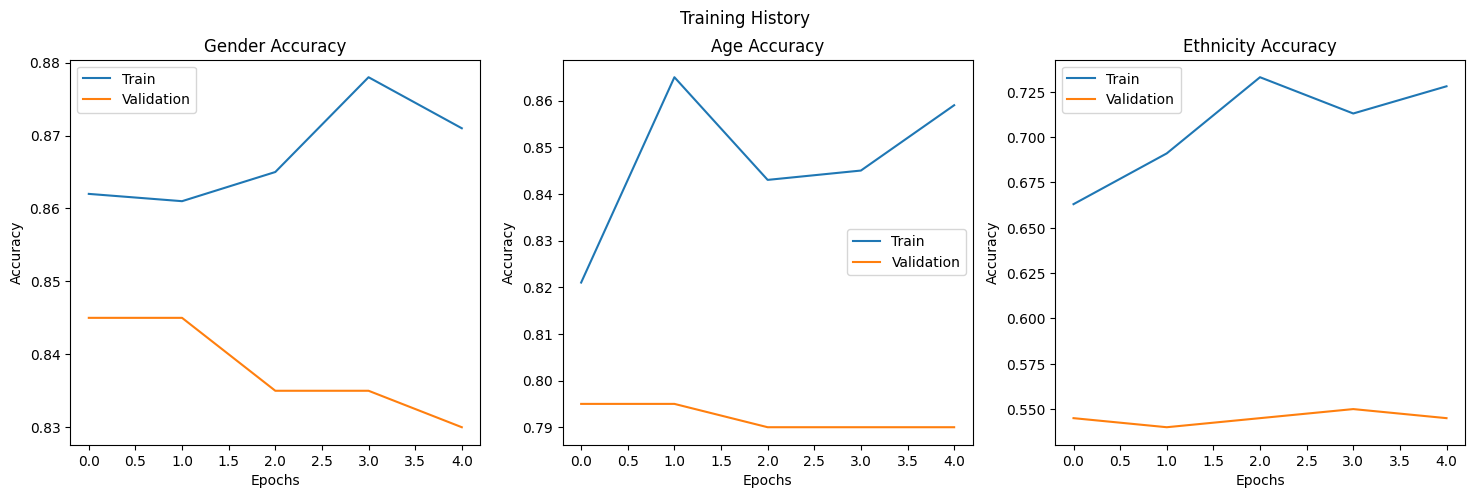

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    metrics = ['gender_accuracy', 'val_gender_accuracy',
               'age_accuracy', 'val_age_accuracy',
               'ethnicity_accuracy', 'val_ethnicity_accuracy']

    plt.figure(figsize=(18, 5))

    for i, metric in enumerate([('gender', 'Gender Accuracy'),
                                ('age', 'Age Accuracy'),
                                ('ethnicity', 'Ethnicity Accuracy')]):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[f'{metric[0]}_accuracy'], label='Train')
        plt.plot(history.history[f'val_{metric[0]}_accuracy'], label='Validation')
        plt.title(metric[1])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.suptitle(title)
    plt.show()

plot_training_history(history_finetuned_exp2)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step


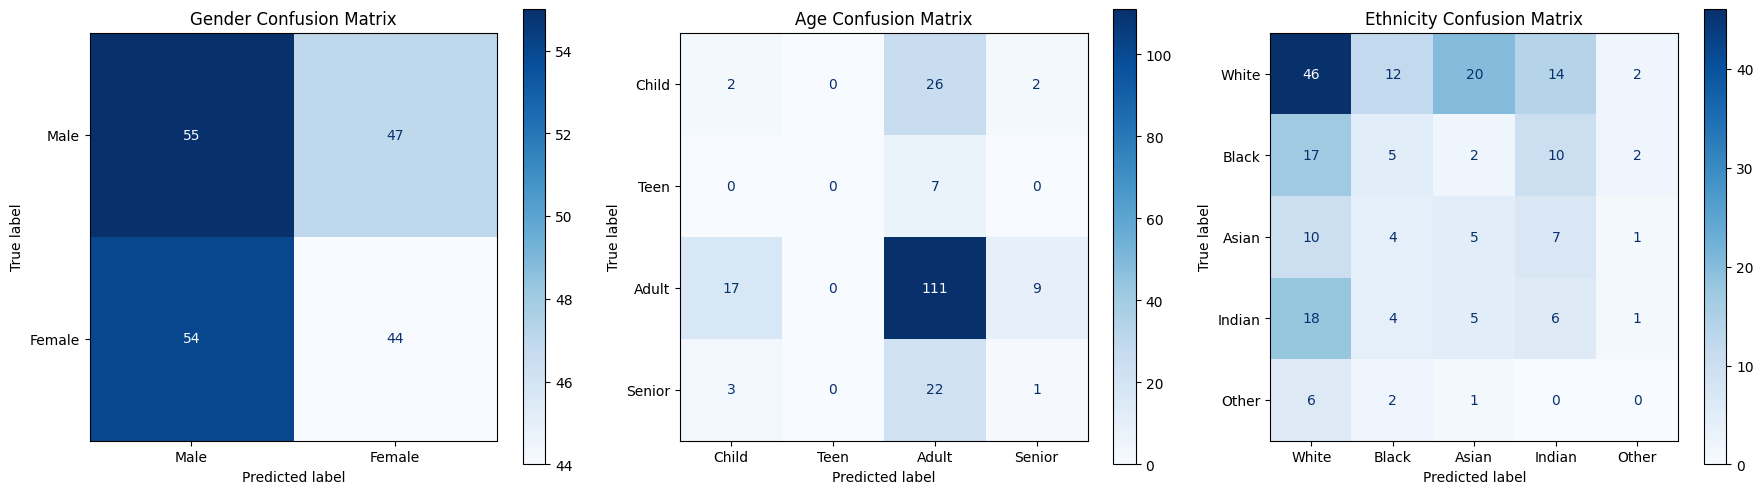

In [ ]:
# Predict on validation data
val_preds = model_exp2.predict(val_gen)
pred_gender = (val_preds[0] > 0.5).astype(int).flatten()
pred_age = np.argmax(val_preds[1], axis=1)
pred_ethnicity = np.argmax(val_preds[2], axis=1)

true_gender = val_df['gender'].values
true_age = val_df['age_class'].values # Use 'age_class' as this is what the generator outputs for age
true_ethnicity = val_df['ethnicity'].values

# Confusion matrices
plt.figure(figsize=(18, 5))
for i, (true, pred, title, labels) in enumerate([
    (true_gender, pred_gender, "Gender", ["Male", "Female"]),
    (true_age, pred_age, "Age", ["Child", "Teen", "Adult", "Senior"]), # Updated age labels to match age_class
    (true_ethnicity, pred_ethnicity, "Ethnicity", ["White", "Black", "Asian", "Indian", "Other"]),
]):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=plt.gca(), values_format='d')
    plt.title(f"{title} Confusion Matrix")

plt.tight_layout()
plt.show()

#**0.6 DROPOUT RATE**

In [ ]:
# 1. Build Model with Dropout
from tensorflow.keras.layers import Dropout # Import the Dropout layer

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.6)(x)  # Regularization

gender_output = Dense(1, activation='sigmoid', name='gender')(x)
age_output = Dense(4, activation='softmax', name='age')(x)
ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

model_exp3 = Model(inputs=base_model.input, outputs=[gender_output, age_output, ethnicity_output])

In [ ]:
# 2. Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# 3. Compile before initial training
model_exp3.compile(
    optimizer=Adam(1e-3),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [ ]:
# 4. Initial training
history_exp3 = model_exp3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 602ms/step - age_accuracy: 0.4909 - age_loss: 1.6721 - ethnicity_accuracy: 0.3120 - ethnicity_loss: 2.3580 - gender_accuracy: 0.6248 - gender_loss: 0.7445 - loss: 4.7545 - val_age_accuracy: 0.7800 - val_age_loss: 0.9763 - val_ethnicity_accuracy: 0.4300 - val_ethnicity_loss: 1.6135 - val_gender_accuracy: 0.8150 - val_gender_loss: 0.4338 - val_loss: 2.7769
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 518ms/step - age_accuracy: 0.7351 - age_loss: 0.8162 - ethnicity_accuracy: 0.4226 - ethnicity_loss: 1.5453 - gender_accuracy: 0.7690 - gender_loss: 0.5261 - loss: 2.8767 - val_age_accuracy: 0.7800 - val_age_loss: 0.7465 - val_ethnicity_accuracy: 0.4750 - val_ethnicity_loss: 1.3868 - val_gender_accuracy: 0.8100 - val_gender_loss: 0.3850 - val_loss: 2.4529
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 550ms/step - age_accuracy: 0.7685 - age_loss: 0.6624 - ethnicity_accuracy: 0.5129 - ethnicity_loss: 1.3402 - gender_accuracy: 0.7971 - gender_loss: 0.4385 - loss: 

In [ ]:
# 5. Unfreeze top 30 layers of base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 6. Re-compile with lower LR for fine-tuning
model_exp3.compile(
    optimizer=Adam(1e-5),
    loss={
        'gender': 'binary_crossentropy',
        'age': 'sparse_categorical_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'accuracy',
        'ethnicity': 'accuracy'
    }
)

In [ ]:
# 7. Fine-tuning
history_finetuned_exp3 = model_exp3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# 8. Evaluation
results = model_exp3.evaluate(val_gen, return_dict=True)
for key, value in results.items():
    print(f"{key}: {value:.4f}")

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 813ms/step - age_accuracy: 0.7775 - age_loss: 0.5850 - ethnicity_accuracy: 0.6153 - ethnicity_loss: 1.1314 - gender_accuracy: 0.8036 - gender_loss: 0.4470 - loss: 2.1221 - val_age_accuracy: 0.7900 - val_age_loss: 0.6792 - val_ethnicity_accuracy: 0.5350 - val_ethnicity_loss: 1.2585 - val_gender_accuracy: 0.8000 - val_gender_loss: 0.4006 - val_loss: 2.3353
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 629ms/step - age_accuracy: 0.7755 - age_loss: 0.5473 - ethnicity_accuracy: 0.6183 - ethnicity_loss: 1.0143 - gender_accuracy: 0.8167 - gender_loss: 0.3933 - loss: 1.9583 - val_age_accuracy: 0.7850 - val_age_loss: 0.6893 - val_ethnicity_accuracy: 0.5350 - val_ethnicity_loss: 1.2210 - val_gender_accuracy: 0.8000 - val_gender_loss: 0.4076 - val_loss: 2.3338
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 692ms/step - age_accuracy: 0.8223 - age_loss: 0.5106 - ethnicity_accuracy: 0.6044 - ethnicity_loss: 1.0995 - gender_accuracy: 0.8234 - gender_loss: 0.3721 - loss: 

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict
val_preds = model_exp3.predict(val_gen)

y_true_gender = val_df['gender'].values
# Use 'age_class' as this is what the generator outputs for age
y_true_age = val_df['age_class'].values
y_true_ethnicity = val_df['ethnicity'].values

# Get predicted classes
y_pred_gender = (val_preds[0] > 0.5).astype(int).flatten()
y_pred_age = np.argmax(val_preds[1], axis=1)
y_pred_ethnicity = np.argmax(val_preds[2], axis=1)

# Classification Reports
print("Classification Report - Gender:")
print(classification_report(y_true_gender, y_pred_gender, target_names=['Male', 'Female']))

print("Classification Report - Age:")
# You might want to add target_names for age and ethnicity for clarity
print(classification_report(y_true_age, y_pred_age, target_names=['Child', 'Teen', 'Adult', 'Senior'])) # Added age labels
print("\nClassification Report - Ethnicity:") # Added newline for readability
print(classification_report(y_true_ethnicity, y_pred_ethnicity, target_names=['White', 'Black', 'Asian', 'Indian', 'Others'])) # Added ethnicity labels

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step
Classification Report - Gender:
              precision    recall  f1-score   support

        Male       0.56      0.57      0.57       102
      Female       0.55      0.54      0.54        98

    accuracy                           0.56       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.55      0.56      0.55       200

Classification Report - Age:
              precision    recall  f1-score   support

       Child       0.21      0.17      0.19        30
        Teen       0.00      0.00      0.00         7
       Adult       0.71      0.86      0.78       137
      Senior       0.22      0.08      0.11        26

    accuracy                           0.62       200
   macro avg       0.28      0.28      0.27       200
weighted avg       0.54      0.62      0.57       200


Classification Report - Ethnicity:
              precision    recall  f1-score   support

       White       0.44      0.48      0.46    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


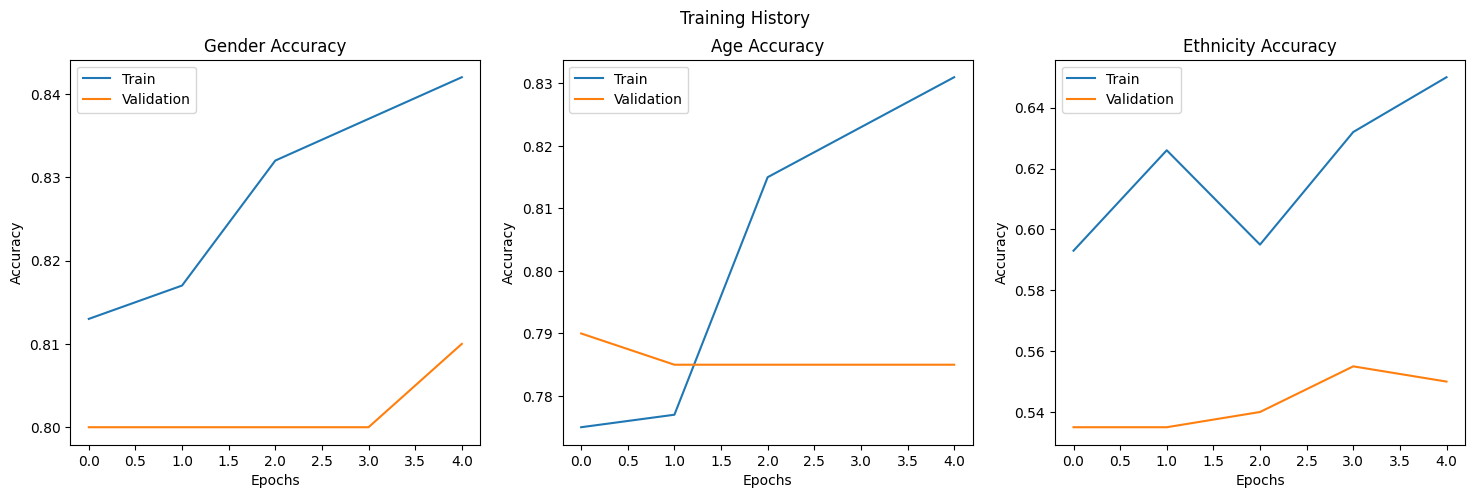

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    metrics = ['gender_accuracy', 'val_gender_accuracy',
               'age_accuracy', 'val_age_accuracy',
               'ethnicity_accuracy', 'val_ethnicity_accuracy']

    plt.figure(figsize=(18, 5))

    for i, metric in enumerate([('gender', 'Gender Accuracy'),
                                ('age', 'Age Accuracy'),
                                ('ethnicity', 'Ethnicity Accuracy')]):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[f'{metric[0]}_accuracy'], label='Train')
        plt.plot(history.history[f'val_{metric[0]}_accuracy'], label='Validation')
        plt.title(metric[1])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.suptitle(title)
    plt.show()

plot_training_history(history_finetuned_exp3)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 785ms/step


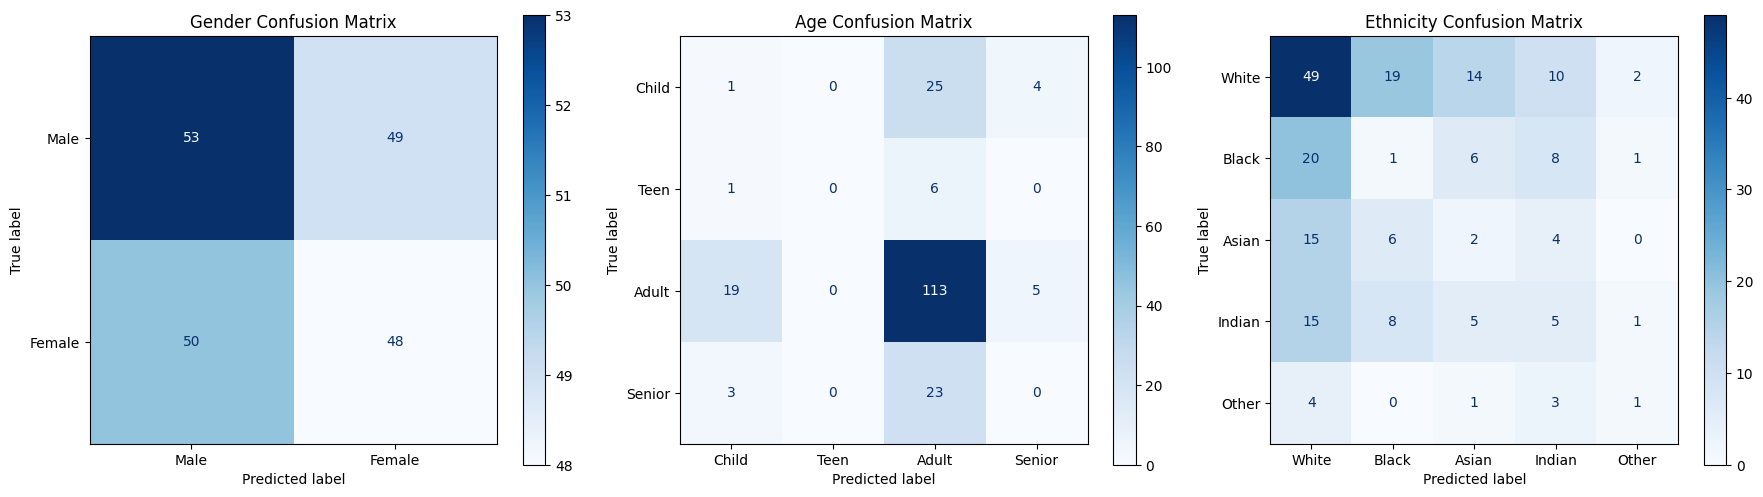

In [ ]:
# Predict on validation data
val_preds = model_exp3.predict(val_gen)
pred_gender = (val_preds[0] > 0.5).astype(int).flatten()
pred_age = np.argmax(val_preds[1], axis=1)
pred_ethnicity = np.argmax(val_preds[2], axis=1)

true_gender = val_df['gender'].values
true_age = val_df['age_class'].values # Use 'age_class' as this is what the generator outputs for age
true_ethnicity = val_df['ethnicity'].values

# Confusion matrices
plt.figure(figsize=(18, 5))
for i, (true, pred, title, labels) in enumerate([
    (true_gender, pred_gender, "Gender", ["Male", "Female"]),
    (true_age, pred_age, "Age", ["Child", "Teen", "Adult", "Senior"]), # Updated age labels to match age_class
    (true_ethnicity, pred_ethnicity, "Ethnicity", ["White", "Black", "Asian", "Indian", "Other"]),
]):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=plt.gca(), values_format='d')
    plt.title(f"{title} Confusion Matrix")

plt.tight_layout()
plt.show()

#**Category 2 Change Optimizer**

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def create_model_with_optimizer(optimizer):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)
    age_output = Dense(4, activation='softmax', name='age')(x)
    ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

    model = Model(inputs=base_model.input, outputs=[gender_output, age_output, ethnicity_output])
    model.compile(
        optimizer=optimizer,
        loss={
            'gender': 'binary_crossentropy',
            'age': 'sparse_categorical_crossentropy',
            'ethnicity': 'sparse_categorical_crossentropy'
        },
        loss_weights={'gender': 1.0, 'age': 1.5, 'ethnicity': 1.2},
        metrics={'gender': 'accuracy', 'age': 'accuracy', 'ethnicity': 'accuracy'}
    )
    return model

# Define optimizers for experiments
optimizers = {
    'Experiment 1 - Adam': Adam(learning_rate=1e-4),
    'Experiment 2 - RMSprop': RMSprop(learning_rate=5e-5),
    'Experiment 3 - SGD': SGD(learning_rate=1e-4, momentum=0.9)
}

for name, opt in optimizers.items():
    print(f"\nRunning {name}")
    model = create_model_with_optimizer(opt)
    history = model.fit(train_gen, validation_data=val_gen, epochs=3)

    # Extract training accuracy from last epoch
    gender_acc = history.history['gender_accuracy'][-1]
    age_acc = history.history['age_accuracy'][-1]
    ethnicity_acc = history.history['ethnicity_accuracy'][-1]

    print(f"Training Accuracy after last epoch:")
    print(f"  Gender accuracy: {gender_acc:.3f}")
    print(f"  Age accuracy: {age_acc:.3f}")
    print(f"  Ethnicity accuracy: {ethnicity_acc:.3f}")

    # Evaluate precision, recall, f1
    metrics = evaluate_model(model, val_gen)
    print(f"Evaluation Metrics for {name}:")
    for task, scores in metrics.items():
        print(f" {task.capitalize()}: Precision={scores['precision']:.3f}, Recall={scores['recall']:.3f}, F1={scores['f1_score']:.3f}")


Running Experiment 1 - Adam


<ipython-input-82-3a0666aa5441>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2129']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 851ms/step - age_accuracy: 0.3955 - age_loss: 1.4310 - ethnicity_accuracy: 0.3106 - ethnicity_loss: 1.7400 - gender_accuracy: 0.5240 - gender_loss: 0.7490 - loss: 4.9695 - val_age_accuracy: 0.1550 - val_age_loss: 5.2936 - val_ethnicity_accuracy: 0.2100 - val_ethnicity_loss: 2.5821 - val_gender_accuracy: 0.6950 - val_gender_loss: 0.7377 - val_loss: 11.7739
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 788ms/step - age_accuracy: 0.7630 - age_loss: 0.6518 - ethnicity_accuracy: 0.5737 - ethnicity_loss: 1.1205 - gender_accuracy: 0.7527 - gender_loss: 0.4962 - loss: 2.8196 - val_age_accuracy: 0.2100 - val_age_loss: 4.1950 - val_ethnicity_accuracy: 0.2350 - val_ethnicity_loss: 2.5003 - val_gender_accuracy: 0.7300 - val_gender_loss: 0.7032 - val_loss: 10.2482
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 725ms/step - age_accuracy: 0.8665 - age_loss: 0.4158 - ethnicity_accuracy: 0.7158 - ethnicity_loss: 0.8537 - gender_accuracy: 0.8456 - gender_loss: 0.3841 - loss: 2.0211 -

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2129']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Evaluation Metrics for Experiment 1 - Adam:
 Gender: Precision=0.804, Recall=0.740, F1=0.725
 Age: Precision=0.734, Recall=0.235, F1=0.193
 Ethnicity: Precision=0.367, Recall=0.265, F1=0.274

Running Experiment 2 - RMSprop


<ipython-input-82-3a0666aa5441>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2287']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 804ms/step - age_accuracy: 0.4254 - age_loss: 1.4241 - ethnicity_accuracy: 0.2938 - ethnicity_loss: 1.8261 - gender_accuracy: 0.5292 - gender_loss: 0.7943 - loss: 5.1284 - val_age_accuracy: 0.2550 - val_age_loss: 2.6176 - val_ethnicity_accuracy: 0.3200 - val_ethnicity_loss: 2.3556 - val_gender_accuracy: 0.6400 - val_gender_loss: 0.8942 - val_loss: 7.3746
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 778ms/step - age_accuracy: 0.7124 - age_loss: 0.8014 - ethnicity_accuracy: 0.4806 - ethnicity_loss: 1.3034 - gender_accuracy: 0.7182 - gender_loss: 0.5585 - loss: 3.3187 - val_age_accuracy: 0.3300 - val_age_loss: 2.1673 - val_ethnicity_accuracy: 0.3150 - val_ethnicity_loss: 1.9444 - val_gender_accuracy: 0.6600 - val_gender_loss: 0.9087 - val_loss: 6.7422
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 782ms/step - age_accuracy: 0.8051 - age_loss: 0.5714 - ethnicity_accuracy: 0.5952 - ethnicity_loss: 1.0452 - gender_accuracy: 0.8113 - gender_loss: 0.4645 - loss: 2.5728 - v

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2287']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Evaluation Metrics for Experiment 2 - RMSprop:
 Gender: Precision=0.755, Recall=0.670, F1=0.638
 Age: Precision=0.819, Recall=0.455, F1=0.531
 Ethnicity: Precision=0.350, Recall=0.320, F1=0.324

Running Experiment 3 - SGD


<ipython-input-82-3a0666aa5441>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2445']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 842ms/step - age_accuracy: 0.4283 - age_loss: 1.3620 - ethnicity_accuracy: 0.1900 - ethnicity_loss: 2.0526 - gender_accuracy: 0.5364 - gender_loss: 0.7598 - loss: 5.2670 - val_age_accuracy: 0.6400 - val_age_loss: 1.2226 - val_ethnicity_accuracy: 0.2400 - val_ethnicity_loss: 2.2416 - val_gender_accuracy: 0.5550 - val_gender_loss: 0.9530 - val_loss: 5.4622
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 751ms/step - age_accuracy: 0.6700 - age_loss: 0.9579 - ethnicity_accuracy: 0.3596 - ethnicity_loss: 1.6177 - gender_accuracy: 0.6280 - gender_loss: 0.6404 - loss: 4.0137 - val_age_accuracy: 0.7000 - val_age_loss: 1.1775 - val_ethnicity_accuracy: 0.3000 - val_ethnicity_loss: 2.0790 - val_gender_accuracy: 0.6200 - val_gender_loss: 0.7818 - val_loss: 4.9673
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 688ms/step - age_accuracy: 0.7702 - age_loss: 0.7047 - ethnicity_accuracy: 0.4660 - ethnicity_loss: 1.3777 - gender_accuracy: 0.7210 - gender_loss: 0.5504 - loss: 3.2580 - v

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2445']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Evaluation Metrics for Experiment 3 - SGD:
 Gender: Precision=0.684, Recall=0.680, F1=0.679
 Age: Precision=0.607, Recall=0.725, F1=0.653
 Ethnicity: Precision=0.353, Recall=0.365, F1=0.326


# **Category 3 Changing Learning Rate**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def create_model(lr):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)
    age_output = Dense(4, activation='softmax', name='age')(x)
    ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

    model = Model(inputs=base_model.input, outputs=[gender_output, age_output, ethnicity_output])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={
            'gender': 'binary_crossentropy',
            'age': 'sparse_categorical_crossentropy',
            'ethnicity': 'sparse_categorical_crossentropy'
        },
        loss_weights={'gender': 1.0, 'age': 1.5, 'ethnicity': 1.2},
        metrics={'gender': 'accuracy', 'age': 'accuracy', 'ethnicity': 'accuracy'}
    )
    return model

def evaluate_model(model, val_gen):
    y_true = {'gender': [], 'age': [], 'ethnicity': []}
    y_pred = {'gender': [], 'age': [], 'ethnicity': []}

    for i in range(len(val_gen)):
        x_val, y_val = val_gen[i]
        preds = model.predict(x_val)

        # Access true labels by keys
        gender_true = y_val['gender']
        gender_pred = (preds[0] > 0.5).astype(int)

        age_true = y_val['age']
        age_pred = np.argmax(preds[1], axis=1)

        ethnicity_true = y_val['ethnicity']
        ethnicity_pred = np.argmax(preds[2], axis=1)

        y_true['gender'].extend(gender_true)
        y_pred['gender'].extend(gender_pred.flatten())

        y_true['age'].extend(age_true)
        y_pred['age'].extend(age_pred)

        y_true['ethnicity'].extend(ethnicity_true)
        y_pred['ethnicity'].extend(ethnicity_pred)

    # Calculate metrics
    metrics = {}
    for task in ['gender', 'age', 'ethnicity']:
        precision = precision_score(y_true[task], y_pred[task], average='weighted', zero_division=0)
        recall = recall_score(y_true[task], y_pred[task], average='weighted', zero_division=0)
        f1 = f1_score(y_true[task], y_pred[task], average='weighted', zero_division=0)
        metrics[task] = {'precision': precision, 'recall': recall, 'f1_score': f1}
    return metrics

# Define learning rates for experiments
learning_rates = {
    'Experiment 1 - lr=0.001': 1e-3,
    'Experiment 2 - lr=0.0001': 1e-4,
    'Experiment 3 - lr=0.00001': 1e-5
}

for name, lr in learning_rates.items():
    print(f"\nRunning {name}")
    model = create_model(lr)
    history = model.fit(train_gen, validation_data=val_gen, epochs=3)

    # Extract accuracy from training history (last epoch)
    gender_acc = history.history['gender_accuracy'][-1]
    age_acc = history.history['age_accuracy'][-1]
    ethnicity_acc = history.history['ethnicity_accuracy'][-1]

    print(f"Training Accuracy after last epoch:")
    print(f"  Gender accuracy: {gender_acc:.3f}")
    print(f"  Age accuracy: {age_acc:.3f}")
    print(f"  Ethnicity accuracy: {ethnicity_acc:.3f}")

    # Evaluate precision, recall, f1
    metrics = evaluate_model(model, val_gen)
    print(f"Evaluation Metrics for {name}:")
    for task, scores in metrics.items():
        print(f" {task.capitalize()}: Precision={scores['precision']:.3f}, Recall={scores['recall']:.3f}, F1={scores['f1_score']:.3f}")


Running Experiment 1 - lr=0.001


<ipython-input-81-6dc505fd659c>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1655']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 826ms/step - age_accuracy: 0.5962 - age_loss: 1.1604 - ethnicity_accuracy: 0.3652 - ethnicity_loss: 1.7374 - gender_accuracy: 0.6774 - gender_loss: 0.6179 - loss: 4.4301 - val_age_accuracy: 0.7100 - val_age_loss: 3.3856 - val_ethnicity_accuracy: 0.3800 - val_ethnicity_loss: 2.3799 - val_gender_accuracy: 0.5400 - val_gender_loss: 1.7390 - val_loss: 9.9205
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 868ms/step - age_accuracy: 0.8454 - age_loss: 0.4503 - ethnicity_accuracy: 0.6686 - ethnicity_loss: 0.9305 - gender_accuracy: 0.8678 - gender_loss: 0.3373 - loss: 2.0850 - val_age_accuracy: 0.7650 - val_age_loss: 2.0764 - val_ethnicity_accuracy: 0.2600 - val_ethnicity_loss: 3.7374 - val_gender_accuracy: 0.6700 - val_gender_loss: 1.1316 - val_loss: 9.0027
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 756ms/step - age_accuracy: 0.8962 - age_loss: 0.3256 - ethnicity_accuracy: 0.7683 - ethnicity_loss: 0.6358 - gender_accuracy: 0.8934 - gender_loss: 0.2653 - loss: 1.5208 - v

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1655']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Evaluation Metrics for Experiment 1 - lr=0.001:
 Gender: Precision=0.773, Recall=0.765, F1=0.763
 Age: Precision=0.619, Recall=0.740, F1=0.673
 Ethnicity: Precision=0.275, Recall=0.210, F1=0.154

Running Experiment 2 - lr=0.0001


<ipython-input-81-6dc505fd659c>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1813']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 839ms/step - age_accuracy: 0.4633 - age_loss: 1.3346 - ethnicity_accuracy: 0.2455 - ethnicity_loss: 1.8542 - gender_accuracy: 0.5584 - gender_loss: 0.7387 - loss: 4.9673 - val_age_accuracy: 0.2250 - val_age_loss: 3.2224 - val_ethnicity_accuracy: 0.2050 - val_ethnicity_loss: 2.7826 - val_gender_accuracy: 0.7200 - val_gender_loss: 0.6675 - val_loss: 8.7612
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 712ms/step - age_accuracy: 0.8082 - age_loss: 0.5472 - ethnicity_accuracy: 0.5592 - ethnicity_loss: 1.1736 - gender_accuracy: 0.7821 - gender_loss: 0.4876 - loss: 2.7086 - val_age_accuracy: 0.3650 - val_age_loss: 1.9930 - val_ethnicity_accuracy: 0.2000 - val_ethnicity_loss: 2.8089 - val_gender_accuracy: 0.7400 - val_gender_loss: 0.6739 - val_loss: 6.9901
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 686ms/step - age_accuracy: 0.8521 - age_loss: 0.4286 - ethnicity_accuracy: 0.7095 - ethnicity_loss: 0.8622 - gender_accuracy: 0.8578 - gender_loss: 0.3748 - loss: 2.0513 - v

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1813']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Evaluation Metrics for Experiment 2 - lr=0.0001:
 Gender: Precision=0.753, Recall=0.735, F1=0.730
 Age: Precision=0.622, Recall=0.385, F1=0.417
 Ethnicity: Precision=0.360, Recall=0.230, F1=0.221

Running Experiment 3 - lr=0.00001


<ipython-input-81-6dc505fd659c>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1971']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 918ms/step - age_accuracy: 0.1629 - age_loss: 2.0331 - ethnicity_accuracy: 0.2385 - ethnicity_loss: 1.9165 - gender_accuracy: 0.5067 - gender_loss: 0.7865 - loss: 6.1395 - val_age_accuracy: 0.0950 - val_age_loss: 4.0529 - val_ethnicity_accuracy: 0.2450 - val_ethnicity_loss: 2.4713 - val_gender_accuracy: 0.5000 - val_gender_loss: 0.9331 - val_loss: 10.0853
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 765ms/step - age_accuracy: 0.2654 - age_loss: 1.6437 - ethnicity_accuracy: 0.2582 - ethnicity_loss: 1.7575 - gender_accuracy: 0.5417 - gender_loss: 0.7351 - loss: 5.3131 - val_age_accuracy: 0.1050 - val_age_loss: 4.1285 - val_ethnicity_accuracy: 0.2350 - val_ethnicity_loss: 2.4379 - val_gender_accuracy: 0.5150 - val_gender_loss: 0.9405 - val_loss: 10.1089
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 785ms/step - age_accuracy: 0.4004 - age_loss: 1.3187 - ethnicity_accuracy: 0.3049 - ethnicity_loss: 1.7211 - gender_accuracy: 0.5376 - gender_loss: 0.7054 - loss: 4.7494 -

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1971']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Evaluation Metrics for Experiment 3 - lr=0.00001:
 Gender: Precision=0.526, Recall=0.525, F1=0.523
 Age: Precision=0.733, Recall=0.105, F1=0.053
 Ethnicity: Precision=0.276, Recall=0.240, F1=0.217


#**Category 4 Change Batch Sizes**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def create_model_with_dropout(lr):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers initially

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)
    age_output = Dense(4, activation='softmax', name='age')(x)
    ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x)

    model = Model(inputs=base_model.input, outputs=[gender_output, age_output, ethnicity_output])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={
            'gender': 'binary_crossentropy',
            'age': 'sparse_categorical_crossentropy',
            'ethnicity': 'sparse_categorical_crossentropy'
        },
        loss_weights={'gender': 1.0, 'age': 1.5, 'ethnicity': 1.2},
        metrics={'gender': 'accuracy', 'age': 'accuracy', 'ethnicity': 'accuracy'}
    )
    return model

def evaluate_model(model, val_gen):
    y_true = {'gender': [], 'age': [], 'ethnicity': []}
    y_pred = {'gender': [], 'age': [], 'ethnicity': []}

    for i in range(len(val_gen)):
        x_val, y_val = val_gen[i]
        preds = model.predict(x_val, verbose=0)

        gender_true = y_val['gender']
        gender_pred = (preds[0] > 0.5).astype(int)

        age_true = y_val['age']
        age_pred = np.argmax(preds[1], axis=1)

        ethnicity_true = y_val['ethnicity']
        ethnicity_pred = np.argmax(preds[2], axis=1)

        y_true['gender'].extend(gender_true)
        y_pred['gender'].extend(gender_pred.flatten())

        y_true['age'].extend(age_true)
        y_pred['age'].extend(age_pred)

        y_true['ethnicity'].extend(ethnicity_true)
        y_pred['ethnicity'].extend(ethnicity_pred)

    metrics = {}
    for task in ['gender', 'age', 'ethnicity']:
        precision = precision_score(y_true[task], y_pred[task], average='weighted', zero_division=0)
        recall = recall_score(y_true[task], y_pred[task], average='weighted', zero_division=0)
        f1 = f1_score(y_true[task], y_pred[task], average='weighted', zero_division=0)
        metrics[task] = {'precision': precision, 'recall': recall, 'f1_score': f1}
    return metrics

# === Run Experiments for Different Batch Sizes ===

batch_sizes = [64, 128, 256]

for batch_size in batch_sizes:
    print(f"\n\n===== Running Experiment - Batch Size: {batch_size} =====")

    # Create data generators
    train_gen = MultiOutputDataGenerator(train_df, batch_size=batch_size, img_size=(96, 96))
    val_gen = MultiOutputDataGenerator(val_df, batch_size=batch_size, img_size=(96, 96), shuffle=False)

    # Create and train model (Phase 1: frozen layers)
    model = create_model_with_dropout(lr=1e-3)
    history1 = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)

    # Unfreeze last 30 layers for fine-tuning
    for layer in model.layers[-30:]:
        if hasattr(layer, 'trainable'):
            layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss={
            'gender': 'binary_crossentropy',
            'age': 'sparse_categorical_crossentropy',
            'ethnicity': 'sparse_categorical_crossentropy'
        },
        loss_weights={'gender': 1.0, 'age': 1.5, 'ethnicity': 1.2},
        metrics={'gender': 'accuracy', 'age': 'accuracy', 'ethnicity': 'accuracy'}
    )
    history2 = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)

    # Combine last epoch's accuracy from both phases
    gender_acc = history2.history['gender_accuracy'][-1]
    age_acc = history2.history['age_accuracy'][-1]
    ethnicity_acc = history2.history['ethnicity_accuracy'][-1]

    print(f"\nTraining Accuracy after fine-tuning (last epoch):")
    print(f"  Gender accuracy: {gender_acc:.3f}")
    print(f"  Age accuracy: {age_acc:.3f}")
    print(f"  Ethnicity accuracy: {ethnicity_acc:.3f}")

    # Evaluate precision, recall, f1-score
    metrics = evaluate_model(model, val_gen)
    print(f"\nEvaluation Metrics for Batch Size {batch_size}:")
    for task, scores in metrics.items():
        print(f" {task.capitalize()}: Precision={scores['precision']:.3f}, Recall={scores['recall']:.3f}, F1={scores['f1_score']:.3f}")




===== Running Experiment - Batch Size: 64 =====


<ipython-input-26-3e69207fe551>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_477']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - age_accuracy: 0.5164 - age_loss: 1.9616 - ethnicity_accuracy: 0.2544 - ethnicity_loss: 3.1671 - gender_accuracy: 0.5344 - gender_loss: 1.1396 - loss: 7.8991 - val_age_accuracy: 0.6800 - val_age_loss: 1.1111 - val_ethnicity_accuracy: 0.3500 - val_ethnicity_loss: 1.6078 - val_gender_accuracy: 0.6750 - val_gender_loss: 0.6456 - val_loss: 4.2985
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - age_accuracy: 0.6602 - age_loss: 1.2314 - ethnicity_accuracy: 0.3409 - ethnicity_loss: 2.4187 - gender_accuracy: 0.6735 - gender_loss: 0.8073 - loss: 5.5492 - val_age_accuracy: 0.7500 - val_age_loss: 1.0013 - val_ethnicity_accuracy: 0.4700 - val_ethnicity_loss: 1.4414 - val_gender_accuracy: 0.7250 - val_gender_loss: 0.6407 - val_loss: 3.9198
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - age_accuracy: 0.6846 - age_loss: 0.9567 - ethnicity_accuracy: 0.4155 - ethnicity_loss: 2.0637 - gender_accuracy: 0.7370 - gender_loss: 0.6029 - loss: 4.5215 - val_age_ac

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_477']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)



Evaluation Metrics for Batch Size 64:
 Gender: Precision=0.741, Recall=0.735, F1=0.731
 Age: Precision=0.726, Recall=0.665, F1=0.687
 Ethnicity: Precision=0.500, Recall=0.530, F1=0.488


===== Running Experiment - Batch Size: 128 =====


<ipython-input-26-3e69207fe551>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_636']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - age_accuracy: 0.5144 - age_loss: 1.8910 - ethnicity_accuracy: 0.2617 - ethnicity_loss: 3.0079 - gender_accuracy: 0.5515 - gender_loss: 1.2657 - loss: 7.7113 - val_age_accuracy: 0.7150 - val_age_loss: 1.2944 - val_ethnicity_accuracy: 0.3300 - val_ethnicity_loss: 1.9954 - val_gender_accuracy: 0.6750 - val_gender_loss: 0.7911 - val_loss: 5.0140
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - age_accuracy: 0.6088 - age_loss: 1.4455 - ethnicity_accuracy: 0.3065 - ethnicity_loss: 2.4426 - gender_accuracy: 0.6422 - gender_loss: 0.8687 - loss: 5.9642 - val_age_accuracy: 0.7300 - val_age_loss: 0.9815 - val_ethnicity_accuracy: 0.3950 - val_ethnicity_loss: 1.8509 - val_gender_accuracy: 0.7500 - val_gender_loss: 0.5662 - val_loss: 4.2076
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - age_accuracy: 0.6598 - age_loss: 1.1703 - ethnicity_accuracy: 0.3703 - ethnicity_loss: 2.2677 - gender_accuracy: 0.7184 - gender_loss: 0.6703 - loss: 5.1474 - val_age_accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_636']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)



Evaluation Metrics for Batch Size 128:
 Gender: Precision=0.776, Recall=0.775, F1=0.775
 Age: Precision=0.740, Recall=0.765, F1=0.752
 Ethnicity: Precision=0.431, Recall=0.445, F1=0.436


===== Running Experiment - Batch Size: 256 =====


<ipython-input-26-3e69207fe551>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(96, 96, 3)))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_795']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - age_accuracy: 0.5651 - age_loss: 1.8926 - ethnicity_accuracy: 0.1810 - ethnicity_loss: 3.7147 - gender_accuracy: 0.4296 - gender_loss: 1.4191 - loss: 8.7244 - val_age_accuracy: 0.6800 - val_age_loss: 1.1480 - val_ethnicity_accuracy: 0.3650 - val_ethnicity_loss: 2.3088 - val_gender_accuracy: 0.5500 - val_gender_loss: 0.8177 - val_loss: 5.3103
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - age_accuracy: 0.6021 - age_loss: 1.6251 - ethnicity_accuracy: 0.3134 - ethnicity_loss: 3.0786 - gender_accuracy: 0.5153 - gender_loss: 1.1735 - loss: 7.3094 - val_age_accuracy: 0.7050 - val_age_loss: 1.0771 - val_ethnicity_accuracy: 0.3750 - val_ethnicity_loss: 2.2156 - val_gender_accuracy: 0.6450 - val_gender_loss: 0.6429 - val_loss: 4.9172
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - age_accuracy: 0.6460 - age_loss: 1.3598 - ethnicity_accuracy: 0.3423 - ethnicity_loss: 2.8351 - gender_accuracy: 0.5976 - gender_loss: 0.9798 - loss: 6.4156 - val_age_accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_795']
Received: inputs=Tensor(shape=(32, 96, 96, 3))
  warnings.warn(msg)



Evaluation Metrics for Batch Size 256:
 Gender: Precision=0.777, Recall=0.775, F1=0.774
 Age: Precision=0.724, Recall=0.745, F1=0.729
 Ethnicity: Precision=0.388, Recall=0.425, F1=0.396
